In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models import DenseNet
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/densenet")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

# model

In [9]:
model = DenseNet(output_size=num_class, num_layer=169).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
DenseNet                                           --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─DenseBlock: 2-3                             --
│    │    └─ModuleList: 3-4                        335,040
│    └─TransitionBlock: 2-4                        --
│    │    └─ConvBnRelu: 3-5                        33,280
│    │    └─AvgPool2d: 3-6                         --
├─Sequential: 1-3                                  --
│    └─DenseBlock: 2-5                             --
│    │    └─ModuleList: 3-7                        919,680
│    └─TransitionBlock: 2-6                        --
│    

# training

In [11]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [12]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [13]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [14]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 818/818 [15:45<00:00,  1.16s/it]


epoch 1 : 0.06457438828164033


100%|██████████| 818/818 [03:02<00:00,  4.49it/s]


epoch 2 : 0.05780245229365045


100%|██████████| 818/818 [03:16<00:00,  4.17it/s]


epoch 3 : 0.05484977784432234


100%|██████████| 818/818 [03:02<00:00,  4.48it/s]


epoch 4 : 0.05082631762843114


100%|██████████| 818/818 [03:05<00:00,  4.40it/s]


epoch 5 : 0.04846680918958922


100%|██████████| 818/818 [02:55<00:00,  4.65it/s]


epoch 6 : 0.04525965869353861


100%|██████████| 818/818 [03:10<00:00,  4.29it/s]


epoch 7 : 0.04374844551286808


100%|██████████| 818/818 [02:39<00:00,  5.14it/s]


epoch 8 : 0.04072076431760214


100%|██████████| 818/818 [02:40<00:00,  5.08it/s]


epoch 9 : 0.04072236110545094


100%|██████████| 818/818 [02:36<00:00,  5.22it/s]

epoch 10 : 0.03903714935853166


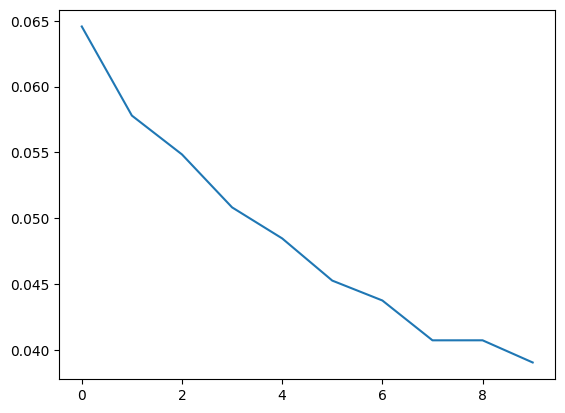

In [15]:
plt.plot(training_loss)

# inference

In [16]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [17]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [18]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [19]:
evaluator = ClassificationEvaluator(num_class, device)

In [20]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 819/819 [01:51<00:00,  7.35it/s]


In [21]:
print(confusion_matrix)

[[3720  158   95   49  181  109  132  120  189  110]
 [ 515 1331  203   22   48    2  324  103   53   22]
 [ 160  100  927    7   18    8   42   94   39   51]
 [ 138   33    2 1587   45   24    9    5  232   37]
 [ 307   57   24   63 2271   15   22   83  155  101]
 [ 897   17   21   27   51  309    9   21  147  169]
 [ 386  314   99    7   36    2  729  261   24    8]
 [ 276   98   73    2   66   11  192  991   73   38]
 [ 214   53    7  268   47   54   24   29 4018  107]
 [ 399   29   22   72   85   90   14   44  276  831]]


In [22]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.7649599012954966
cavallo   : 0.5074342356080823
elefante  : 0.6410788381742739
farfalla  : 0.7514204545454546
gallina   : 0.7330535829567463
gatto     : 0.18525179856115107
mucca     : 0.39067524115755625
pecora    : 0.5445054945054945
ragno     : 0.8334370462559635
scoiattolo: 0.4462943071965628


In [23]:
per_class_acc.mean()

0.5798110900256782

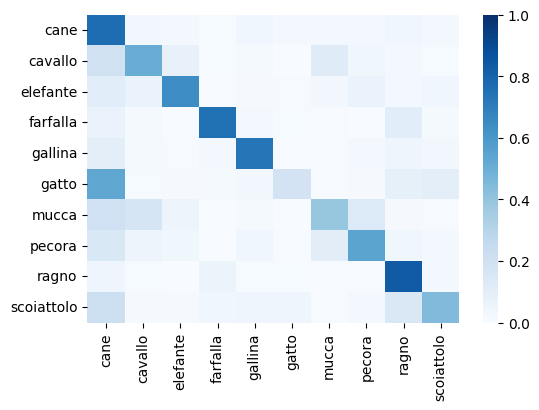

In [27]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [30]:
# image from internet
import requests
from io import BytesIO

demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
# demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [31]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

cavallo


In [25]:
model_path = artifact_path / 'densenet169.pth'

In [32]:
torch.save(model.state_dict(), model_path)

In [33]:
get_file_size(model_path)

'48.64MB'

In [34]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>